In [23]:
import os
import sys

import re
import numpy as np
import scipy.ndimage
import imgviz
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

cwd = os.getcwd()
pwd = cwd[:cwd.rfind('/')]
sys.path.append(pwd)

from dataloader import DatasetClean, DatasetTrainClean

In [3]:
issave = Fase

NameError: name 'Fase' is not defined

## Ground truth

In [4]:
# Dataset
data_path = '../data/'
cln_dataset = DatasetClean(data_path)
trn_dataset = DatasetTrainClean(data_path)
labs = ['bckgrnd', 'person', 'bike', 'car', 'drone', 'boat', 'animal', 'obstacle', 'constrn', 'plant', 'road', 'sky']
cmap = np.array([
        #  R,   G,   B
        (  0,   0,   0),  #  Background
        # (192, 128, 128),  #  Person
        (255, 127,  14),  #  Person
        (  0, 128,   0),  #  Bike
        # (128, 128, 128),  #  Car
        (152,  78, 163),  #  Car
        (128,   0,   0),  #  Drone
        (  0,   0, 128),  #  Boat
        (192,   0, 128),  #  Animal
        (192,   0,   0),  #  Obstacle
        (192, 128,   0),  #  Construction
        (  0,  64,   0),  #  Plant
        (128, 128,   0),  #  Road
        (  0, 128, 128)   #  Sky
    ])

def plot_rgb(img, label_img):
    # process rgb
    img_base = imgviz.color.rgb2gray(img)
    # labelviz = imgviz.label2rgb(label=label_img, image=img_base)
    labelviz = imgviz.label2rgb(
            label=label_img, image=img_base, 
            label_names=labs, colormap=cmap, font_size=25, loc="centroid"
        )
    return labelviz

def get_edge(label_img):
    img_sobel = scipy.ndimage.sobel(label_img)
    img_sobel = (np.abs(img_sobel) > 0).astype('uint8')
    img_edge = np.zeros((img_sobel.shape[0], img_sobel.shape[1], 4))
    img_edge[:, :, 3] = img_sobel
    return img_edge

(-0.5, 1279.5, 719.5, -0.5)

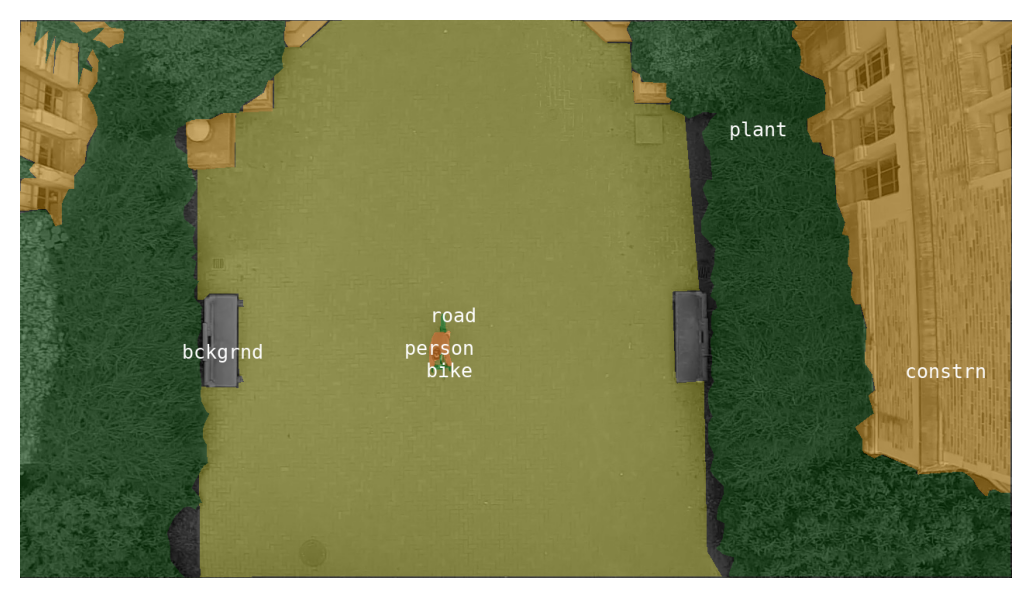

In [5]:
# get image
idx = 222
img, label_img = cln_dataset[idx]
img = img.astype('uint8')
img_edge = get_edge(label_img)

plt.figure(dpi=200)
labelviz = plot_rgb(img, label_img)
plt.imshow(labelviz)
# plt.imshow(img_edge)
plt.axis("off")

In [13]:
# for i, idx in enumerate([0, 800, 1200, 2000, 2400]):
# for i, idx in enumerate([1100, 2100, 2200]):
for i, idx in enumerate([100, 200, 300, 400, 480, 500, 600]):
    # get image
    img, label_img = cln_dataset[idx]
    img = img.astype('uint8')
    # labelviz = imgviz.label2rgb(label=label_img, colormap=cmap)
    labelviz = plot_rgb(img, label_img)

    plt.figure()
    plt.figure(dpi=200)
    # plt.imshow(img)
    plt.imshow(labelviz)
    plt.axis("off")
    plt.savefig('./figs/case/img_{}.pdf'.format(idx), bbox_inches='tight')
    # plt.savefig('./figs/lab_{}.pdf'.format(idx), bbox_inches='tight')
    plt.close()

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

## Model output

In [6]:
import torch
import torchvision.transforms as transforms
from model import *
from dataloader import DatasetVal
from logger import Logger, ModelLogger

In [7]:
mname = 'deeplabv3'
lname = 'focalloss'
flag = '1115'
flag_run = "{}_{}".format(lname, flag)
logger = Logger(save_path='../saved_models/', prj_name=mname, flag_run=flag_run)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def restore_model(mname, logger):
    assert logger.path_existed, f"Path {logger.dir_save} not found"
    model_logger = ModelLogger(logger, state_only=True)
    model_logger.metric_name = 'iou'

    # ===== Model =====
    model = get_model(mname)
    model = model_logger.load_model('best', model=model).to(device)
    model.eval()
    return model

In [8]:
# load dataset and model
val_dataset = DatasetVal('../data/')
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=2, shuffle=False, num_workers=1)
cln_dataloader = torch.utils.data.DataLoader(cln_dataset, batch_size=2, shuffle=False, num_workers=1)
# model = restore_model(mname, logger)

In [12]:
# get image
idx = [222, 223]
xs, ys = [], []
for i in idx:
    x, y = val_dataset[i]
    xs.append(x)
    ys.append(y)
xs = torch.stack(xs)
ys = torch.stack(ys)

# get prediction
with torch.no_grad():
    pred_mask = model(xs.to(device))
pred_mask = torch.softmax(pred_mask, dim=1)
pred = torch.argmax(pred_mask, dim=1)
pred = pred.cpu()

# transfer to label map
h, w = pred.shape[1:]
pred = transforms.functional.crop(pred, 8, 0, h-16, w)

(-0.5, 1279.5, 719.5, -0.5)

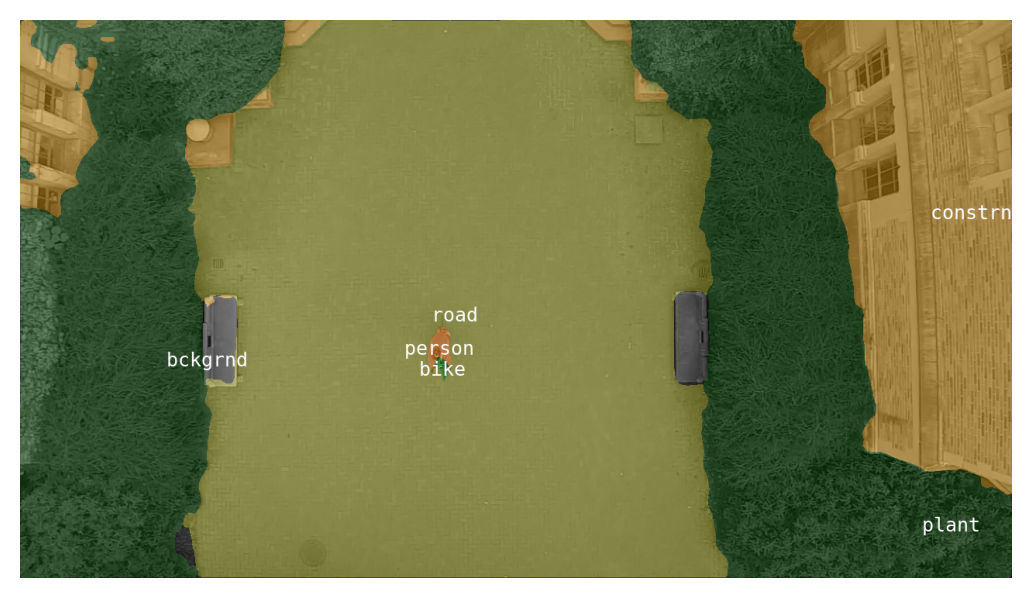

In [13]:
# get base image
batch_id = 0
img, _ = cln_dataset[idx[batch_id]]
img = img.astype('uint8')
label_pred = pred[batch_id].numpy()

plt.figure(dpi=200)
labelviz = plot_rgb(img, label_pred)
plt.imshow(labelviz)
plt.axis("off")

## Side by side

In [15]:
loss_lst = ['ce', 'focal', 'dice', 'iou', 'tversky']
flag_lst = ['crossentropy_1119', 'focalloss_0.75_1119', 'dice_1119', 'iouloss2_1118', 'tversky_0.70_0.30_1.00_1118']
mname = 'deeplabv3plus'
img_dict = {
    'truth': {}
}
idx = [100, 200, 300, 400, 480, 500, 600]

In [16]:
for l, f in zip(loss_lst, flag_lst):
    logger = Logger(save_path='../saved_models/', prj_name=mname, flag_run=f)
    model = restore_model(mname, logger)
    img_dict[l] = {}

    # get image
    xs, ys = [], []
    for i in idx:
        x, y = val_dataset[i]
        xs.append(x)
        ys.append(y)
    xs = torch.stack(xs)
    ys = torch.stack(ys)

    # get prediction
    with torch.no_grad():
        pred_mask = model(xs.to(device))
    pred_mask = torch.softmax(pred_mask, dim=1)
    pred = torch.argmax(pred_mask, dim=1)
    pred = pred.cpu()
    # transfer to label map
    h, w = pred.shape[1:]
    pred = transforms.functional.crop(pred, 8, 0, h-16, w)

    # get base image
    for batch_id, i in enumerate(idx):
        img, label_img = cln_dataset[i]
        img = img.astype('uint8')
        label_pred = pred[batch_id].numpy()

        img_dict['truth'][i] = plot_rgb(img, label_img)
        img_dict[l][i] = plot_rgb(img, label_pred)


In [ ]:
for batch_id, i in enumerate(idx):
    plt.figure(dpi=1200)
    gs1 = gridspec.GridSpec(1, 6)
    gs1.update(wspace=0.02, hspace=0.0)
    for li, l in enumerate(['truth'] + loss_lst):
        ax = plt.subplot(gs1[li])
        labelviz = img_dict[l][i]
        ax.imshow(labelviz)
        ax.axis("off")
        # plt.tight_layout()
    if issave:
        plt.savefig(f'./figs/case_{i}.pdf', bbox_inches='tight')

## IoU map